### Model Creation - Multi Layer Perceptron
Paper:  
Sigmoid activation function has been considered in this work
as the non-linear transfer function of each neuron. We utilized the
Scikit-Learn library [32] in Python to create the model

**Imports:**

In [1]:
from torch.utils.data import random_split
from matplotlib import pyplot
import pandas as pd
import torch

#### Dataset Loading

In [2]:
def prepare_dataset(dataset_files, delimiter=";"):
    dataframes = []
    data_path = "../data/"
    
    for file in dataset_files:
      df = pd.read_csv(data_path+file, delimiter=delimiter)
              
      label = 0
      if "atk" in file:
        # df.drop(df.columns[0], axis=1, inplace=True) # drop index-column
        label = 1
      df["label"] = label
            
      dataframes.append(df)
        
    concatenated_df = pd.concat(dataframes, axis=0)
    concatenated_df.replace({True: 1, False: 0}, inplace=True) # convert boolean to numbers    
    concatenated_df.drop(columns=["blockNumber", "address", "transactionHash"], inplace=True)

    # Convert dataframe to torch tensor
    data_tensor = torch.tensor(concatenated_df.values, dtype=torch.float)
    
    # Get the input (data samples) without the target information
    X = data_tensor[:, :-1]
    
    # Get the target information
    T = data_tensor[:, -1].unsqueeze(1)

    print("Features: ", concatenated_df.columns)

    print(f"Loaded dataset with {len(concatenated_df)} samples")
    
    return X, T


In [3]:
atk_files = ["insertion_atks_first_atk.csv"]
non_atk_files = ["random_sampled_transactions.csv"]
dataset_files = atk_files + non_atk_files

X, T = prepare_dataset(dataset_files, ",")

Features:  Index(['gasPrice', 'meanGasPriceLastTenBlocks', 'stdGasPriceLastTenBlocks',
       'meanGasPriceLastTenBlocksSameEOA', 'stdGasPriceLastTenBlocksSameEOA',
       'usedGasToken', 'predictedGasPrice', 'label'],
      dtype='object')
Loaded dataset with 39331 samples


#### Split Training and Validation Data

In [4]:
def split_training_data(X, T, train_percentage=0.8):
  
  assert len(X) == len(T)
  
  num_samples = len(X)
  
  train_size = int(train_percentage * num_samples)
  validation_size = num_samples - train_size
    
  # split into 80/20 training/validation
  idx_train, idx_validation = random_split(range(num_samples), [train_size, validation_size])

  
  X_train = X[idx_train]
  T_train = T[idx_train]
  X_val = X[idx_validation]
  T_val = T[idx_validation]

  return X_train, T_train, X_val, T_val

#### Input Data Standardization

In [5]:
def standardize(X_train, X_val):
  # compute statistics
  mean = X_train.mean(dim=0)
  std = X_train.std(dim=0)
  
  torch.save(mean, './mlp-mean.pt')
  torch.save(std, './mlp-std.pt')

  # Check if standard deviation is zero
  zero_std_mask = std == 0
  
  # Standardize both X_train and X_val, excluding columns with zero standard deviation
  X_train = (X_train - mean) / std.masked_fill(zero_std_mask, 1)  # Replace zero std with 1 to avoid division by zero
  X_val = (X_val - mean) / std.masked_fill(zero_std_mask, 1)

  return X_train, X_val

### Network Implementation

**Network Architecture**
- 1 input layer
  - 7 input neurons
- 2 hidden layers
  - 10 hidden neurons
  - 10 hidden neurons
- 1 output layer
  - 1 output neuron    

Using Sigmoid Activation function!

In [6]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(7, 10),  # Input layer to first hidden layer
            torch.nn.Sigmoid(),  # Sigmoid activation function for the first hidden layer
            torch.nn.Linear(10, 10),  # First hidden layer to second hidden layer
            torch.nn.Sigmoid(),  # Sigmoid activation function for the second hidden layer
            torch.nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

**Training Loop**

In [7]:
def accuracy(Z, T):
  # binary classification
  z_sign = (Z >= 0.5).int()
  return torch.mean((z_sign == T).float())

In [8]:
def train(network, loss, X_train, T_train, X_val, T_val, num_epochs=10000, learning_rate=0.1):
  
  optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr=learning_rate,
    momentum=0.9
  )

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(num_epochs):
    # train on training set
    optimizer.zero_grad()
    # ... compute network output on training data
    Z = network(X_train)
    
    # ... compute loss from network output and target data
    J = loss(Z, T_train)
    J.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(J.item())
    # ... compute training set accuracy
    train_acc.append(accuracy(Z, T_train).item())
    
    print(f'Epoch: {epoch}/{num_epochs}')

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z = network(X_val)
      # ... compute loss from network output and target data
      J = loss(Z, T_val)
      # ... remember loss
      val_loss.append(J.item())
      # ... compute validation set accuracy
      val_acc.append(accuracy(Z, T_val).item())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

In [16]:
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel('Loss')
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.set_xlabel("Epoch")
  ax.set_ylabel('Accuracy')
  ax.legend()

Features:  Index(['gasPrice', 'meanGasPriceLastTenBlocks', 'stdGasPriceLastTenBlocks',
       'meanGasPriceLastTenBlocksSameEOA', 'stdGasPriceLastTenBlocksSameEOA',
       'usedGasToken', 'predictedGasPrice', 'label'],
      dtype='object')
Loaded dataset with 39331 samples
Epoch: 0/30000
Epoch: 1/30000
Epoch: 2/30000
Epoch: 3/30000
Epoch: 4/30000
Epoch: 5/30000
Epoch: 6/30000
Epoch: 7/30000
Epoch: 8/30000
Epoch: 9/30000
Epoch: 10/30000
Epoch: 11/30000
Epoch: 12/30000
Epoch: 13/30000
Epoch: 14/30000
Epoch: 15/30000
Epoch: 16/30000
Epoch: 17/30000
Epoch: 18/30000
Epoch: 19/30000
Epoch: 20/30000
Epoch: 21/30000
Epoch: 22/30000
Epoch: 23/30000
Epoch: 24/30000
Epoch: 25/30000
Epoch: 26/30000
Epoch: 27/30000
Epoch: 28/30000
Epoch: 29/30000
Epoch: 30/30000
Epoch: 31/30000
Epoch: 32/30000
Epoch: 33/30000
Epoch: 34/30000
Epoch: 35/30000
Epoch: 36/30000
Epoch: 37/30000
Epoch: 38/30000
Epoch: 39/30000
Epoch: 40/30000
Epoch: 41/30000
Epoch: 42/30000
Epoch: 43/30000
Epoch: 44/30000
Epoch: 45/30000

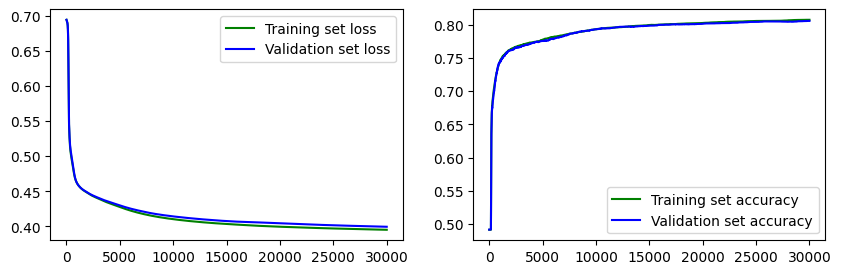

In [10]:
# Load dataset
#dataset_files = ["insertion_atks_first_atk_2500.csv", "insertion_atks_second_atk_2500.csv", "random_sampled_transactions.csv"]

X, T = prepare_dataset(dataset_files, ",")

# Split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T, 0.8)
# Standardize input data
X_train, X_val = standardize(X_train, X_val)

# Initiate the network
network = Network()
# Define loss function
loss = torch.nn.BCEWithLogitsLoss(reduction="mean")

# Train network on our data
results = train(network, loss, X_train, T_train, X_val, T_val, num_epochs=30000, learning_rate=0.1)
train_loss, train_acc, val_loss, val_acc = results

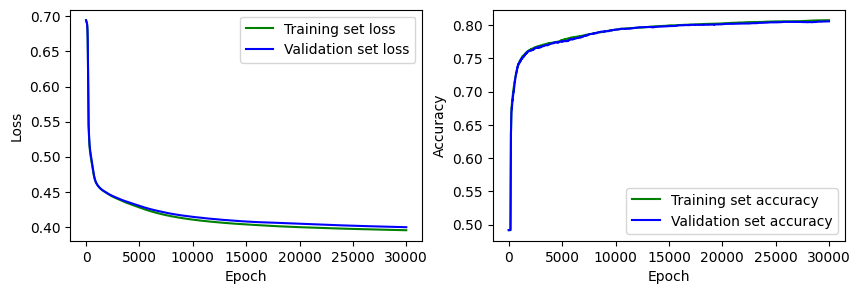

In [17]:
# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

In [11]:
torch.save(network.state_dict(), './front-running-attack-model.pth')

In [12]:
print(val_acc[-1])

0.8056438565254211


#### Comparison to other models

**Random Forest**

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.tree import ExtraTreeClassifier


# Initialize the Random Forest classifier
classifiers = [KNeighborsClassifier(3),
                SVC(kernel="linear", C=0.025, random_state=42),
                SVC(gamma=2, C=1, random_state=42),
                #GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
                DecisionTreeClassifier(max_depth=5, random_state=42),
                RandomForestClassifier(
                    max_depth=5, n_estimators=10, max_features=1, random_state=42),
                AdaBoostClassifier(algorithm="SAMME", random_state=42),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),
                MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=10000),
                ExtraTreeClassifier()]

for classifier in classifiers:
    print(classifier)
    classifier.fit(X_train, T_train)
    predictions = classifier.predict(X_val)
    accuracy = accuracy_score(T_val, predictions)
    f1 = f1_score(T_val.numpy(), predictions, average='weighted')
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print('--------------------------------')

KNeighborsClassifier(n_neighbors=3)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.7635693402821915
F1-Score: 0.7634945312961703
--------------------------------
SVC(C=0.025, kernel='linear', random_state=42)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7077666200584721
F1-Score: 0.68932671645633
--------------------------------
SVC(C=1, gamma=2, random_state=42)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7778060251684251
F1-Score: 0.7727688798739759
--------------------------------
DecisionTreeClassifier(max_depth=5, random_state=42)
Accuracy: 0.8161942290580908
F1-Score: 0.8158499593430748
--------------------------------
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10,
                       random_state=42)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8046269225880259
F1-Score: 0.8045432195807515
--------------------------------
AdaBoostClassifier(algorithm='SAMME', random_state=42)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8004321850769035
F1-Score: 0.7984960325956554
--------------------------------
GaussianNB()
Accuracy: 0.6622600737256896
F1-Score: 0.6275167074010247
--------------------------------
QuadraticDiscriminantAnalysis()
Accuracy: 0.6585737892462183
F1-Score: 0.6216575151834042
--------------------------------
MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=10000)


C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\larsh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7891191051226643
F1-Score: 0.7866384418346282
--------------------------------
ExtraTreeClassifier()
Accuracy: 0.7696707766620059
F1-Score: 0.7696797027939329
--------------------------------
